In [1]:
from scripts import bookdatafunctions as bdf
import pandas as pd
import seaborn as sns
import matplotlib
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
#Constants

#In the deprel column
#Dependency relation types in Finnish UD
DEPRELS = ['root', 'nsubj', 'advmod', 'obl', 'obj', 'conj', 'aux', 'cc', 'amod', 'nmod:poss', 'mark', 'cop', 'nsubj:cop', 'advcl', 'xcomp', 'case', 'det', 'ccomp', 'nmod', 'parataxis', 'acl:relcl', 'acl', 'xcomp:ds', 'discourse', 'nummod', 'fixed', 'cop:own', 'appos', 'flat:name', 'compound:nn', 'aux:pass', 'vocative', 'nmod:gobj', 'nmod:gsubj', 'compound:prt', 'csubj:cop', 'flat:foreign', 'orphan', 'cc:preconj', 'csubj', 'compound', 'flat', 'goeswith']

#In the feats column
#Cases in Finnihs UD
CASES = ['Case=Nom', 'Case=Gen', 'Case=Par', 'Case=Ill', 'Case=Ine', 'Case=Ela', 'Case=Ade', 'Case=All', 'Case=Ess', 'Case=Abl', 'Case=Tra', 'Case=Acc', 'Case=Ins', 'Case=Abe', 'Case=Com']
#Verb forms in Finnish UD
VERBFORMS = ['VerbForm=Fin', 'VerbForm=Inf', 'VerbForm=Part']
#Verb tenses in Finnish UD
VERBTENSES = ['Tense=Pres', 'Tense=Past']
#Verb voices in Finnish UD
VERBVOICES = ['Voice=Act', 'Voice=Pass']
#Verb moods in Finnish UD
VERBMOODS = ['Mood=Ind', 'Mood=Cnd', 'Mood=Imp']
#Verb 'person' in Finnish UD (aka first person, second person and so on)
PERSONS = ['Person=0', 'Person=1', 'Person=2', 'Person=3']
#Verb 'number' in Finnish UD (aka first singluar person [me] or first plural person [we] and so on)
NUMBERS = ['Number=Sing', 'Number=Plur']
#Connegative (aka verb that has been given a negative meaning by 'ei')
CONNEGATIVE = ['Connegative=Yes']
#Degrees in Finnish UD (positive, comparative, and superlative)
DEGREES = ['Degree=Pos','Degree=Cmp','Degree=Sup']

#In the upos column
#POS tags in Finnish UD
POS = ['NOUN', 'VERB', 'PRON', 'ADV', 'AUX', 'ADJ', 'PROPN', 'CCONJ', 'SCONJ', 'ADP', 'NUM', 'INTJ']


ALL_FEATS = DEPRELS + CASES + VERBFORMS + VERBTENSES + VERBVOICES + VERBMOODS + PERSONS + NUMBERS + CONNEGATIVE + DEGREES + POS 

ISBN2AGE_PATH = "ISBN2AGE/ISBN2AGE.xlsx"

In [3]:
#Nab corpus and transform ages
corpus = bdf.mapGroup2Age(bdf.initBooksFromConllus("Conllus"), ISBN2AGE_PATH)

In [4]:
#Define sub-corpora

ages = sorted(bdf.getAvailableAges(corpus))
#Generate correct keys/ids
ages_str = list(map(str, ages))
ages_span_2_str = [ages_str[i]+"_"+ages_str[i+1] for i in range(len(ages_str)-1)]
ages_span_3_str = [ages_str[i-1]+"_"+ages_str[i]+"_"+ages_str[i+1] for i in range(1, len(ages_str)-1)]
#Distinct ages
sub_span_1 = [bdf.getDistinctSubCorp(corpus, x) for x in ages]
#Sliding window with span 1 (so 5&6, 6&7, etc.) 
sub_span_2 = [bdf.combineSubCorpDicts([bdf.getDistinctSubCorp(corpus, x), bdf.getDistinctSubCorp(corpus, x+1)]) for x in ages if (x < 15)]
#Sliding window with span 2 (so 5&6&7, 6&7&8, etc.)
sub_span_3 = [bdf.combineSubCorpDicts([bdf.getRangeSubCorp(corpus, x)]) for x in ages if (5 < x < 15)]

In [5]:
#Combine info into dicts for easier usage
sub_corps_1 = dict(zip(ages_str, sub_span_1))
sub_corps_2 = dict(zip(ages_span_2_str, sub_span_2))
sub_corps_3 = dict(zip(ages_span_3_str, sub_span_3))

In [6]:
"""
effect_sizes_1 = {}
for sub1 in sub_corps_1:
    for sub2 in sub_corps_1:
        new_key = str(sub1)+"+"+str(sub2)
        effect_sizes = []
        for deprel in DEPRELS:
            effect_sizes.append( bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_corps_1[sub1], deprel, True), bdf.getDeprelFeaturePerBook(sub_corps_1[sub2], deprel, True)) )
        for ctg in [CASES, VERBFORMS, VERBMOODS, VERBTENSES, VERBVOICES, PERSONS, NUMBERS, CONNEGATIVE, DEGREES]:
            for feat in ctg:
                effect_sizes.append( bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_corps_1[sub1], feat, True), bdf.getFeatsFeaturePerBook(sub_corps_1[sub2], feat, True)) )
        for pos in POS:
            effect_sizes.append( bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_corps_1[sub1], pos, True), bdf.getPosFeaturePerBook(sub_corps_1[sub2], pos, True)) )
        effect_sizes_1[new_key] = effect_sizes
"""

'\neffect_sizes_1 = {}\nfor sub1 in sub_corps_1:\n    for sub2 in sub_corps_1:\n        new_key = str(sub1)+"+"+str(sub2)\n        effect_sizes = []\n        for deprel in DEPRELS:\n            effect_sizes.append( bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_corps_1[sub1], deprel, True), bdf.getDeprelFeaturePerBook(sub_corps_1[sub2], deprel, True)) )\n        for ctg in [CASES, VERBFORMS, VERBMOODS, VERBTENSES, VERBVOICES, PERSONS, NUMBERS, CONNEGATIVE, DEGREES]:\n            for feat in ctg:\n                effect_sizes.append( bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_corps_1[sub1], feat, True), bdf.getFeatsFeaturePerBook(sub_corps_1[sub2], feat, True)) )\n        for pos in POS:\n            effect_sizes.append( bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_corps_1[sub1], pos, True), bdf.getPosFeaturePerBook(sub_corps_1[sub2], pos, True)) )\n        effect_sizes_1[new_key] = effect_sizes\n'

In [7]:
#ef_1_df = pd.DataFrame(effect_sizes_1, index=ALL_FEATS)

In [8]:
effect_sizes_3 = {}
with tqdm(range(len(list(sub_corps_3.keys()))**2), desc="Iterating over subcorpora...") as pbar:
    for key1 in sub_corps_3:
        sub_corpus_1 = sub_corps_3[key1]
        for key2 in sub_corps_3:
            sub_corpus_2 = sub_corps_3[key2]
            new_key = str(key1)+"+"+str(key2)
            effect_sizes = []
            for deprel in DEPRELS:
                effect_sizes.append( bdf.cohensdForSubcorps(bdf.getDeprelFeaturePerBook(sub_corpus_1, deprel, True), bdf.getDeprelFeaturePerBook(sub_corpus_2, deprel, True)) )
            for ctg in [CASES, VERBFORMS, VERBMOODS, VERBTENSES, VERBVOICES, PERSONS, NUMBERS, CONNEGATIVE, DEGREES]:
                for feat in ctg:
                    effect_sizes.append( bdf.cohensdForSubcorps(bdf.getFeatsFeaturePerBook(sub_corpus_1, feat, True), bdf.getFeatsFeaturePerBook(sub_corpus_2, feat, True)) )
            for pos in POS:
                effect_sizes.append( bdf.cohensdForSubcorps(bdf.getPosFeaturePerBook(sub_corpus_1, pos, True), bdf.getPosFeaturePerBook(sub_corpus_2, pos, True)) )
            effect_sizes_3[new_key] = effect_sizes
            pbar.update(1)

Iterating over subcorpora...: 100%|██████████| 81/81 [1:09:52<00:00, 51.76s/it]


<Axes: >

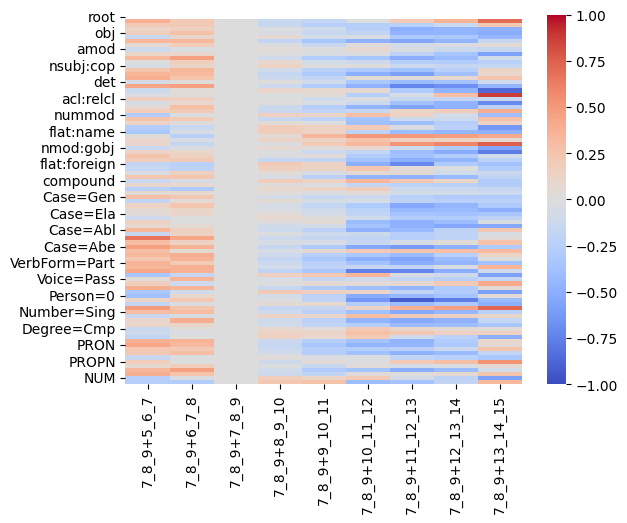

In [374]:
ef_3_df = pd.DataFrame(effect_sizes_3, index=ALL_FEATS)

def sub_columns(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

sns.heatmap(ef_3_df[sub_columns(ef_3_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1)

In [82]:
import numpy as np
import math


non_important = {}
for feat in ALL_FEATS:
    y = ef_3_df.loc[feat].values
    non_important[feat] = np.count_nonzero(abs(y) > 0.5)

In [83]:
from pprint import pprint
#pprint(non_important)

In [396]:
scaling_features_middle = []
for feat in ALL_FEATS:
    temp_df = ef_3_df[sub_columns(ef_3_df.columns, '9')]
    y_1 = temp_df[temp_df.columns[:4]].loc[feat].to_numpy(na_value=0.0)
    y_2 = temp_df[temp_df.columns[5:]].loc[feat].to_numpy(na_value=0.0)
    if ((y_1<0.1).sum() == len(y_1) and (y_2>-0.1).sum() == len(y_2)) or ((y_1>-0.1).sum() == len(y_1) and (y_2<0.1).sum() == len(y_2)):
        if ((abs(y_1)>0.4).sum() > 1) or ((abs(y_2)>0.4).sum() > 1):
            scaling_features_middle.append(feat)

In [397]:
scaling_features_early = []
for feat in ALL_FEATS:
    temp_df = ef_3_df[sub_columns(ef_3_df.columns, '7')]
    y_1 = temp_df[temp_df.columns[:2]].loc[feat].to_numpy(na_value=0.0)
    y_2 = temp_df[temp_df.columns[3:]].loc[feat].to_numpy(na_value=0.0)
    if ((y_1<0.1).sum() == len(y_1) and (y_2>-0.1).sum() == len(y_2)) or ((y_1>-0.1).sum() == len(y_1) and (y_2<0.1).sum() == len(y_2)):
        if ((abs(y_1)>0.4).sum() > 0) or ((abs(y_2)>0.4).sum() > 3):
            scaling_features_early.append(feat)
print(scaling_features_early)

['mark', 'ccomp', 'compound:nn', 'Case=Acc', 'Case=Abe', 'Tense=Past', 'Person=1', 'PRON', 'SCONJ']


In [398]:
dupes_removed = list(set(scaling_features_early+scaling_features_middle))

In [ ]:
testing_df = ef_3_df.copy()
print(len(testing_df))
remove = [key for key in non_important if non_important[key] < 20]
#remove = ['root']
# ,
most_important = ['ccomp','vocative', 'nmod','nmod:gsubj','VerbForm=Part','Connegative=Yes', 'CCONJ', 'AUX','nummod','compound:nn']
most_important = dupes_removed
to_drop = [x for x in ALL_FEATS if x not in most_important]
print(remove)
testing_df_edited = testing_df.drop(to_drop)
print(len(testing_df_edited))

NameError: name 'ef_3_df' is not defined

<Axes: >

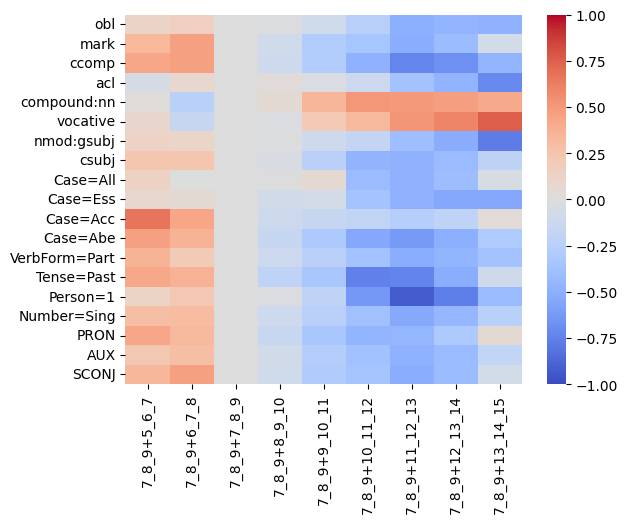

In [400]:
sns.heatmap(testing_df_edited[sub_columns(ef_3_df.columns, '7')], cmap='coolwarm', vmin=-1, vmax=1)

In [401]:
windows = ['5_6_7','6_7_8','7_8_9','8_9_10','9_10_11','10_11_12','11_12_13','12_13_14','13_14_15']
def sub_columns_expanded(columns: list[str], start: str) -> list[str]:
    return [c for c in columns if c[0:len(start)] == start]

In [402]:
temp_1_df = testing_df_edited.copy()
prep_for_cossim = {}
for window in windows:
    prep_for_cossim[window] = temp_1_df[sub_columns(temp_1_df.columns, window)].to_numpy(na_value=0.0)

In [403]:
from sklearn.metrics.pairwise import cosine_similarity
sim_scores = {}
for key1 in prep_for_cossim:
    scores = []
    for key2 in prep_for_cossim:
        scores.append(cosine_similarity(prep_for_cossim[key1], prep_for_cossim[key2]))
    sim_scores[key1] = scores

In [404]:
#Create df
matrix_df = pd.DataFrame.from_dict(sim_scores, orient='index').transpose()
#Set indexes correctly
matrix_df.index = prep_for_cossim.keys()
#Dig out the values from nd.array
matrix_df_2 = matrix_df.copy().applymap(lambda x: x[0][0])

<Axes: >

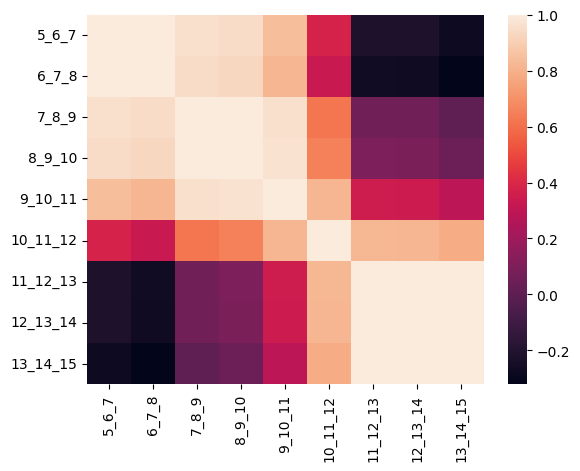

In [405]:
sns.heatmap(matrix_df_2)

In [351]:
print(prep_for_cossim)

{'5_6_7': array([[ 0.        , -0.00239599, -0.43634654, -0.56357642, -0.7376374 ,
        -0.87478587, -1.10089241, -1.04306838, -0.84574954],
       [ 0.        , -0.24774536, -0.08870104, -0.11014333,  0.11385459,
         0.23998351,  0.44622558,  0.52876219,  0.69571037],
       [ 0.        , -0.02691611, -0.12700945, -0.14833597, -0.23697809,
        -0.31955636, -0.50447222, -0.56715563, -0.78794123],
       [ 0.        , -0.1815464 , -0.36700787, -0.51891183, -0.60785817,
        -0.72753871, -0.84345349, -0.77608972, -0.68189877],
       [ 0.        ,  0.3203228 , -0.0997966 , -0.20664885, -0.33637712,
        -0.57922548, -0.6186548 , -0.55890607, -0.23774146]]), '6_7_8': array([[ 0.00239599,  0.        , -0.46596306, -0.61185501, -0.80867528,
        -0.94467175, -1.18213008, -1.10384881, -0.91291779],
       [ 0.24774536,  0.        ,  0.15875955,  0.1397752 ,  0.37568949,
         0.51887638,  0.73421483,  0.82554035,  0.97455573],
       [ 0.02691611,  0.        , -0.1054

In [352]:
temp_2_df = ef_3_df.copy()
temp_dict = {}
for window in windows:
    values = {}
    for feat in ALL_FEATS:
        values[feat] = temp_2_df[sub_columns(temp_2_df.columns, window)].loc[feat].to_numpy().__abs__().sum()
    temp_dict[window] = values

In [353]:
feat_meaning_for_windows = pd.DataFrame(temp_dict.values(), index=temp_dict.keys()).transpose()